## Import the libraries

In [2]:
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt

## Load the different files

In [4]:
img_files = os.listdir("pdf2png")

In [5]:
img = cv2.imread("pdf2png/ZUG-GU22_01_IST_20140922-1.png", 0) # 0 for grayscale

In [6]:
img_file = img_files[0]

## Main functions

In [7]:
def get_door(img, corners, door_length_thres = 70, low_thres = 20, thres = 0.4, debug= True):
    """
    Helps obtain the door coordinates from the image.
    The input is the image and the corners of the image.
    The door length threshold is the maximum length of the door. Low threshold is the minimum length of the door.
    The threshold is the minimum ratio of the door length to the image length.
    Debug shows the added door coordinates in new colors and useful for debugging.

    The output is the image with the doors joined
    """

    img = ~img
    if debug:
        plt.figure(figsize=(50,20))
        plt.imshow(img , cmap="gray")

    doors = []
    img_new = np.stack((img,)*3, axis=-1)
    a, b = np.where(corners>thres*corners.max())
    # For each corner, we check along the row and column to see if there is a door.
    for i in a:
        b_req = np.where(corners[i,:]>thres*corners[i,:].max())[0].reshape(-1)
        for x1, x2 in zip(b_req[:-1], b_req[1:]):
            if x2-x1 < door_length_thres and x2-x1 > low_thres:
                if debug:
                    color = (255, 0, 0)
                else:
                    color = (255,255,255)
                try:
                    if len(np.where(img[x1:x2,i]==0)[0])<=0.1*(x2-x1):
                        img_new = cv2.line(img_new, (int(x1),i), (int(x2),i), color, 2).astype(np.uint8)
                except:
                    pass
    for j in b:
        a_req = np.where(corners[:,j]>thres*corners[:,j].max())[0].reshape(-1)
        for y1, y2 in zip(a_req[:-1], a_req[1:]):
            if np.abs(y2-y1) < door_length_thres and np.abs(y2-y1) > low_thres:
                if debug:
                    color = (0, 255, 255)
                else:
                    color = (255,255,255)
                try:
                    if len(np.where(img[j,y1:y2]==0)[0])<=0.1*np.abs(y2-y1):
                        img_new = cv2.line(img_new, (j,int(y1)), (j,int(y2)), color, 2).astype(np.uint8)
                except:
                    pass
    #             # print(y1,y2)
    if debug:
        plt.figure(figsize=(50,20))
        plt.imshow(~img_new)
    else:
        return ~img_new


In [26]:
def obtain_floorplan(img_file, corner_thres = 0.6, mid_show=True, stairs =False,return_dst = 0):
    
    """
    The function performs all the main steps to obtain the floorplan.
    The input is the image file name.
    stairs is a boolean variable to indicate if the stairs should be extracted from the image.
    The output is the image with the floorplan and the stairs.
    Return_dst returns the image and coordinates of the corners.
    Corner threshold selects corners more aggresively.
    Mid_show is used for debugging.
    """

    img = cv2.imread("pdf2png/" + img_file,0)
    img_gen_crop_init = img[600:1700,200:3400] # Cropping the image to remove the title and the legend. An estimate around the middle of the image.
    if mid_show:
        plt.figure(figsize=(50,20))
        plt.imshow(img_gen_crop_init, cmap="gray")
    img_gen_crop = np.where(img_gen_crop_init > 250, 255, 0).astype(np.uint8) # Binary thresholding

    if mid_show:
        plt.figure(figsize=(50,20))
        plt.imshow(img_gen_crop, cmap="gray")

    img_gen_crop = cv2.erode(img_gen_crop,np.ones((3,3)), iterations=8)
    img_gen_crop = cv2.dilate(img_gen_crop,np.ones((3,3)), iterations=8) # Eroding and dilating to remove noise and join certain walls


    img_cropped = np.stack((img_gen_crop,)*3, axis=-1)
    dst = cv2.cornerHarris(img_gen_crop,2,3,0.04)
    dst = cv2.dilate(dst,None) # Dilating to make the corners more prominent
    a, b = np.where(dst>corner_thres*dst.max())
    if return_dst:
        return dst, img_gen_crop
    img_gen_crop = get_door(img_gen_crop, dst, thres=corner_thres, debug=False) # Obtaining the doors and locks the rooms
    
    if mid_show:
        plt.figure(figsize=(50,20))
        plt.imshow(img_cropped, )
        plt.scatter(b,a , c="r", s=5)
    
    if mid_show:
        plt.figure(figsize=(50,20))
        plt.imshow(img_gen_crop)
    
    ## Obtaining the coordinates of the top left and bottom right corners of the floorplan. The images are aligned according to these coordinates.

    b_min = min(b)
    a_req_min = np.min(np.where(dst[:,b_min]>corner_thres*dst[:,b_min].max()))
    b_max = max(b)
    a_req_max = np.max(np.where(dst[:,b_max]>corner_thres*dst[:,b_max].max()))
    ## The coordinates are saved for offsetting in 3D version
    with open("dilated/harris/del_"+img_file[:-4]+".npz", "wb") as f:
        np.savez(f, a_req_min = a_req_min, a_req_max = a_req_max, b_min = b_min, b_max = b_max)
    img_gen_crop = ~img_gen_crop
    img_gen_crop = np.mean(img_gen_crop,axis=-1)

    ## Remove small objects using connected Components
    img_gen_crop = np.where(img_gen_crop>250, 255, 0).astype(np.int8)
    nb_components, output, stats, centroids = cv2.connectedComponentsWithStats(img_gen_crop, connectivity=4)
    sizes = stats[1:, -1]
    nb_components = nb_components - 1
    if mid_show:
        plt.figure(figsize=(50,20))
        plt.imshow(img_gen_crop, cmap="gray")
    min_size = 200

    img2 = np.zeros((output.shape))
    for i in range(0, nb_components):
        if sizes[i] >= min_size:
            img2[output == i + 1] = 255
    img2 = img2.astype(np.uint8)

    ##After dilation, the stairs occupy a large area. This is used to obtain the stairs and elevators
    if stairs:
        stairs = cv2.dilate(img_cropped,np.ones((3,3)), iterations=25)
        stairs = np.where(np.mean(stairs, axis=-1)>250, 255, 0).astype(np.uint8)
        components = cv2.connectedComponentsWithStats(~stairs, connectivity=4)
        centroids = components[-1]
        print(len(centroids))
        plt.figure(figsize=(50,20))
        plt.imshow(~stairs)
        with open("./dilated/harris/info_"+img_file[:-4]+".npz", "wb") as f:
            np.savez(f, centroids = centroids)
        return None
        
    img = ~img2
    ## The rooms are obtained using connected components
    contours = cv2.findContours(~img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = contours[0] if len(contours) == 2 else contours[1]
    contour_sizes = [(cv2.contourArea(contour), contour) for contour in contours]
    biggest_contour = max(contour_sizes, key=lambda x: x[0])[1]
    mask = np.zeros_like(img)
    cv2.fillPoly(mask, [biggest_contour], 255)
    img[mask == 0] = 255

    # Find the connected components in the house
    ret, labels = cv2.connectedComponents(img)
    img = cv2.cvtColor(img,cv2.COLOR_GRAY2RGB)
    unique = np.unique(labels)
    rooms = []
    for label in unique:
        component = labels == label
        if img[component].sum() == 0 or np.count_nonzero(component) < 10:
            color = 0
        else:
            rooms.append(component)
            color = np.random.randint(0, 250, size=3)
        zero = 0
        if zero in component[0] and zero in component[1]:
            img[component] = color
        else:
            img[component] = 255
    if mid_show:
        plt.figure(figsize=(50,20))
        plt.imshow(img)

    plt.figure(figsize=(50,20))
    plt.imshow(img)

    return rooms, img

    

In [27]:
img_files[-2]

'ZUG-GU22_07_IST_20160907-1.png'

In [28]:
img_file = img_files[-2]

## Example on single room

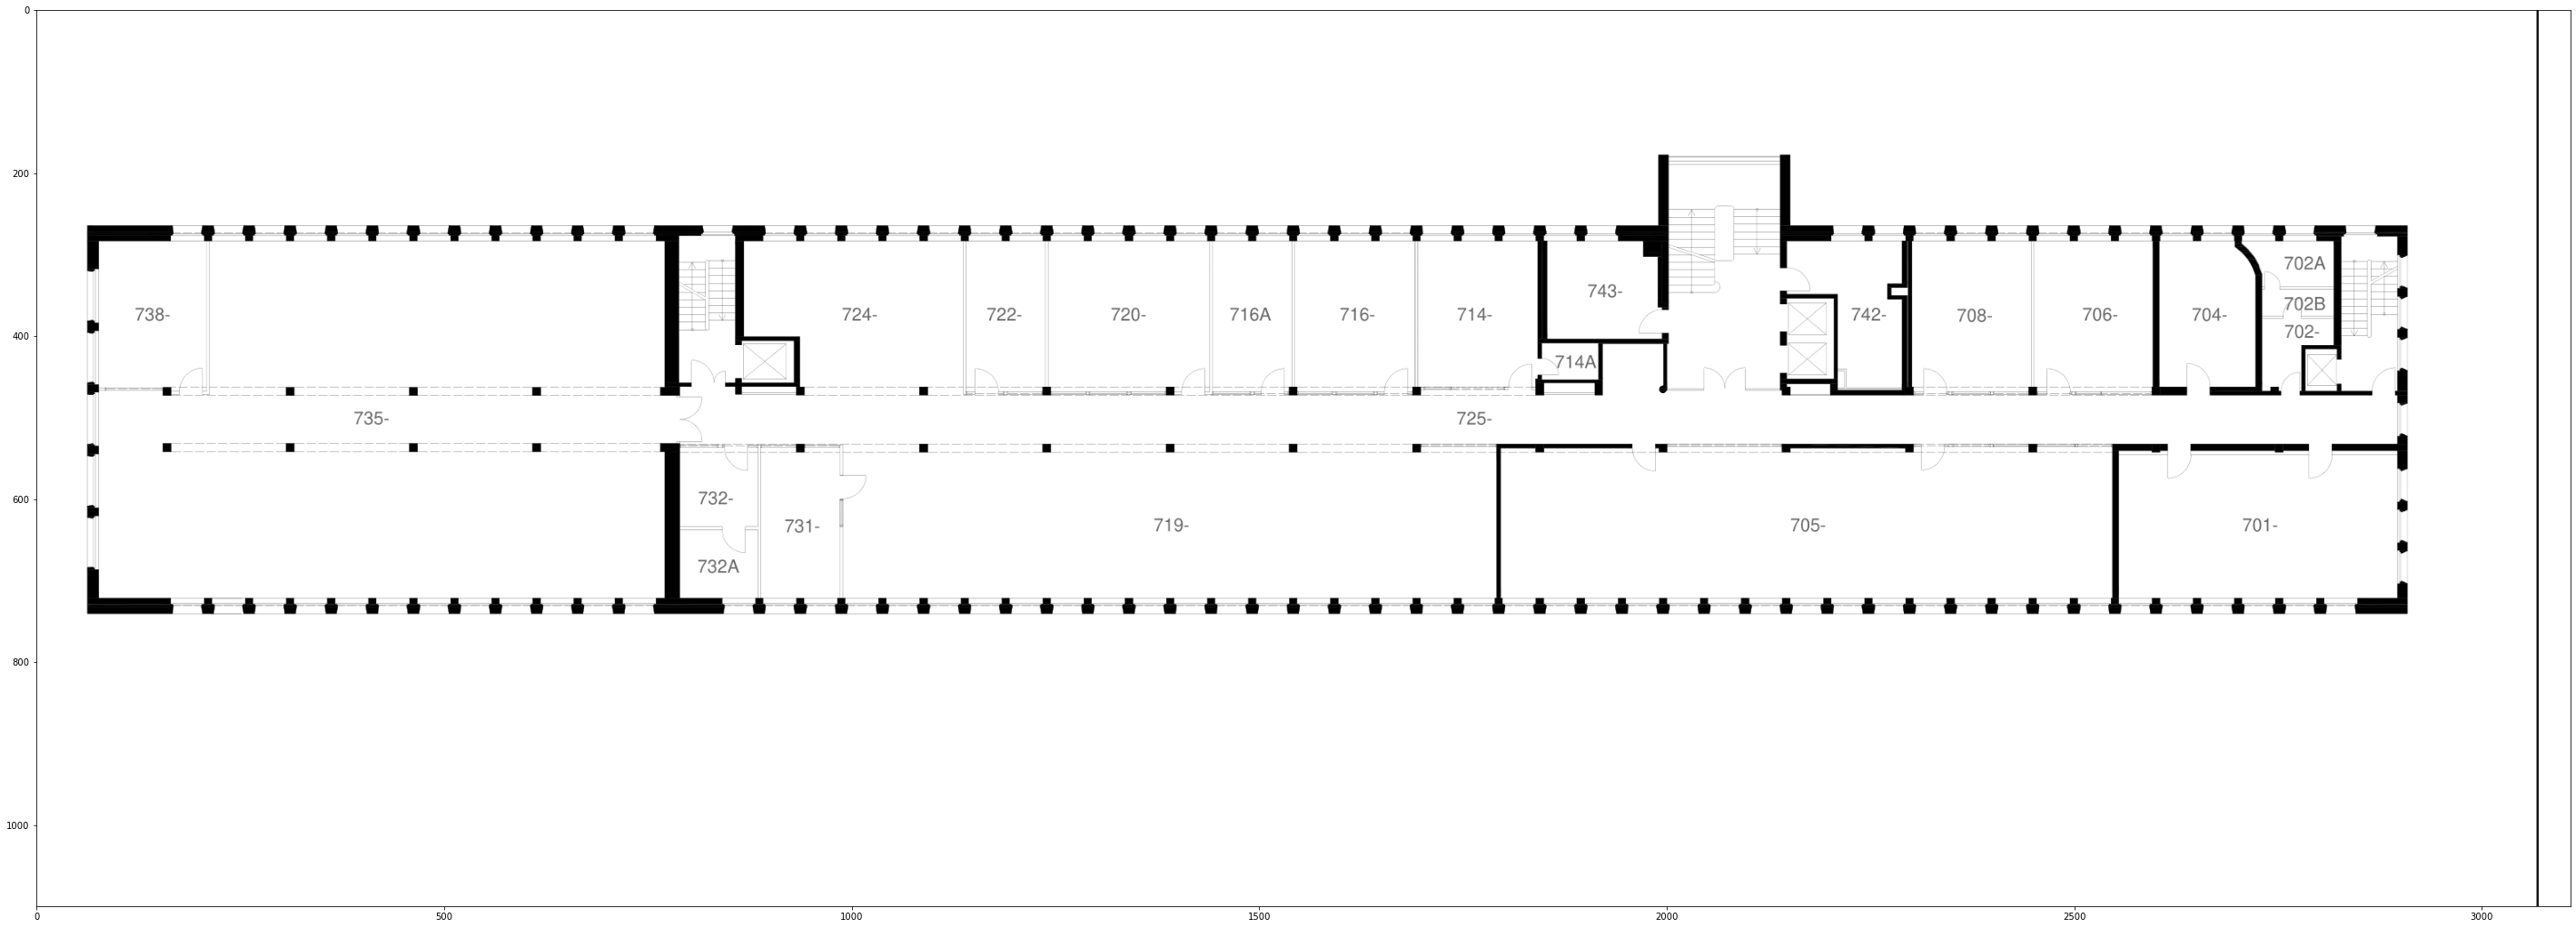

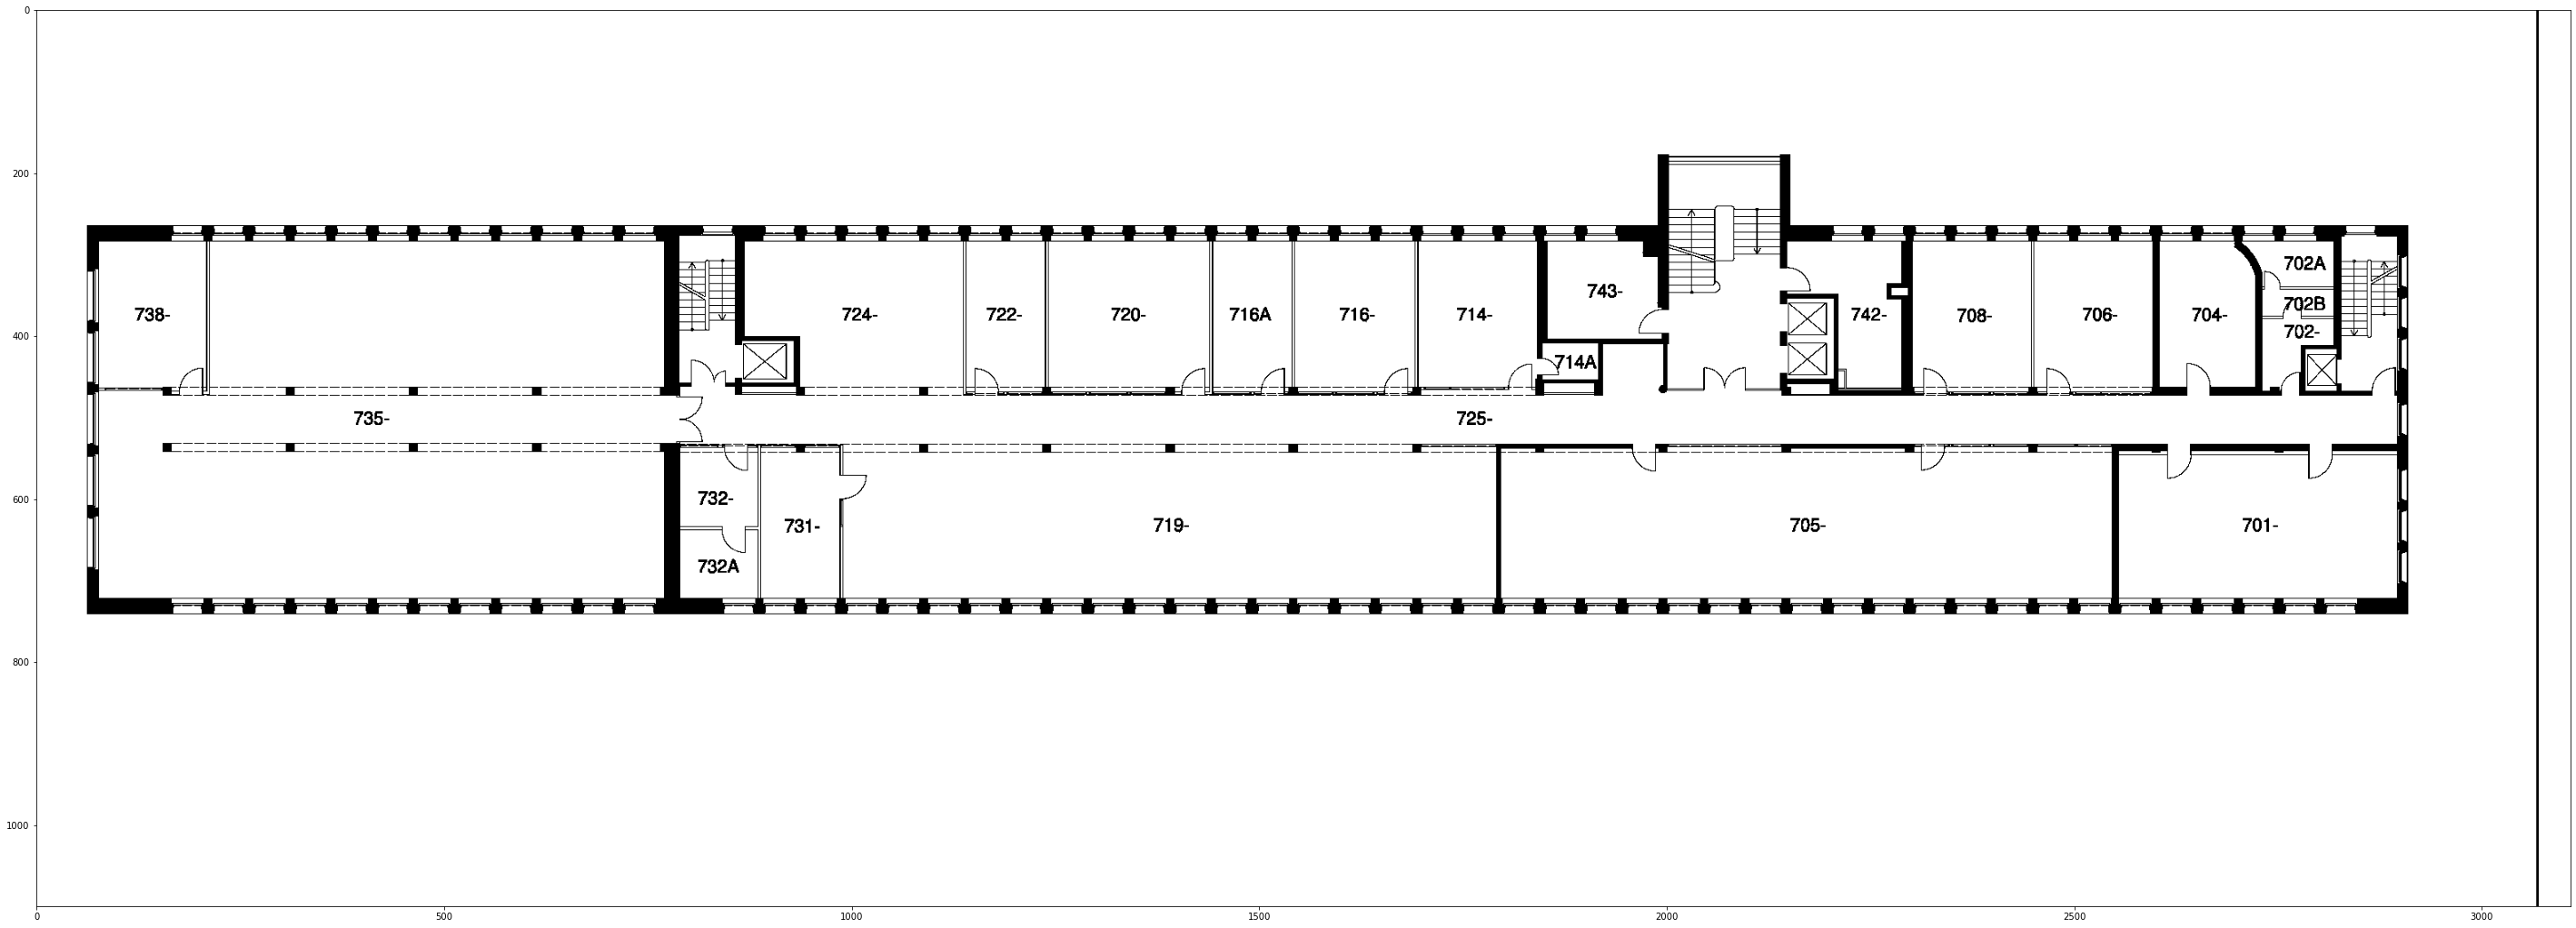

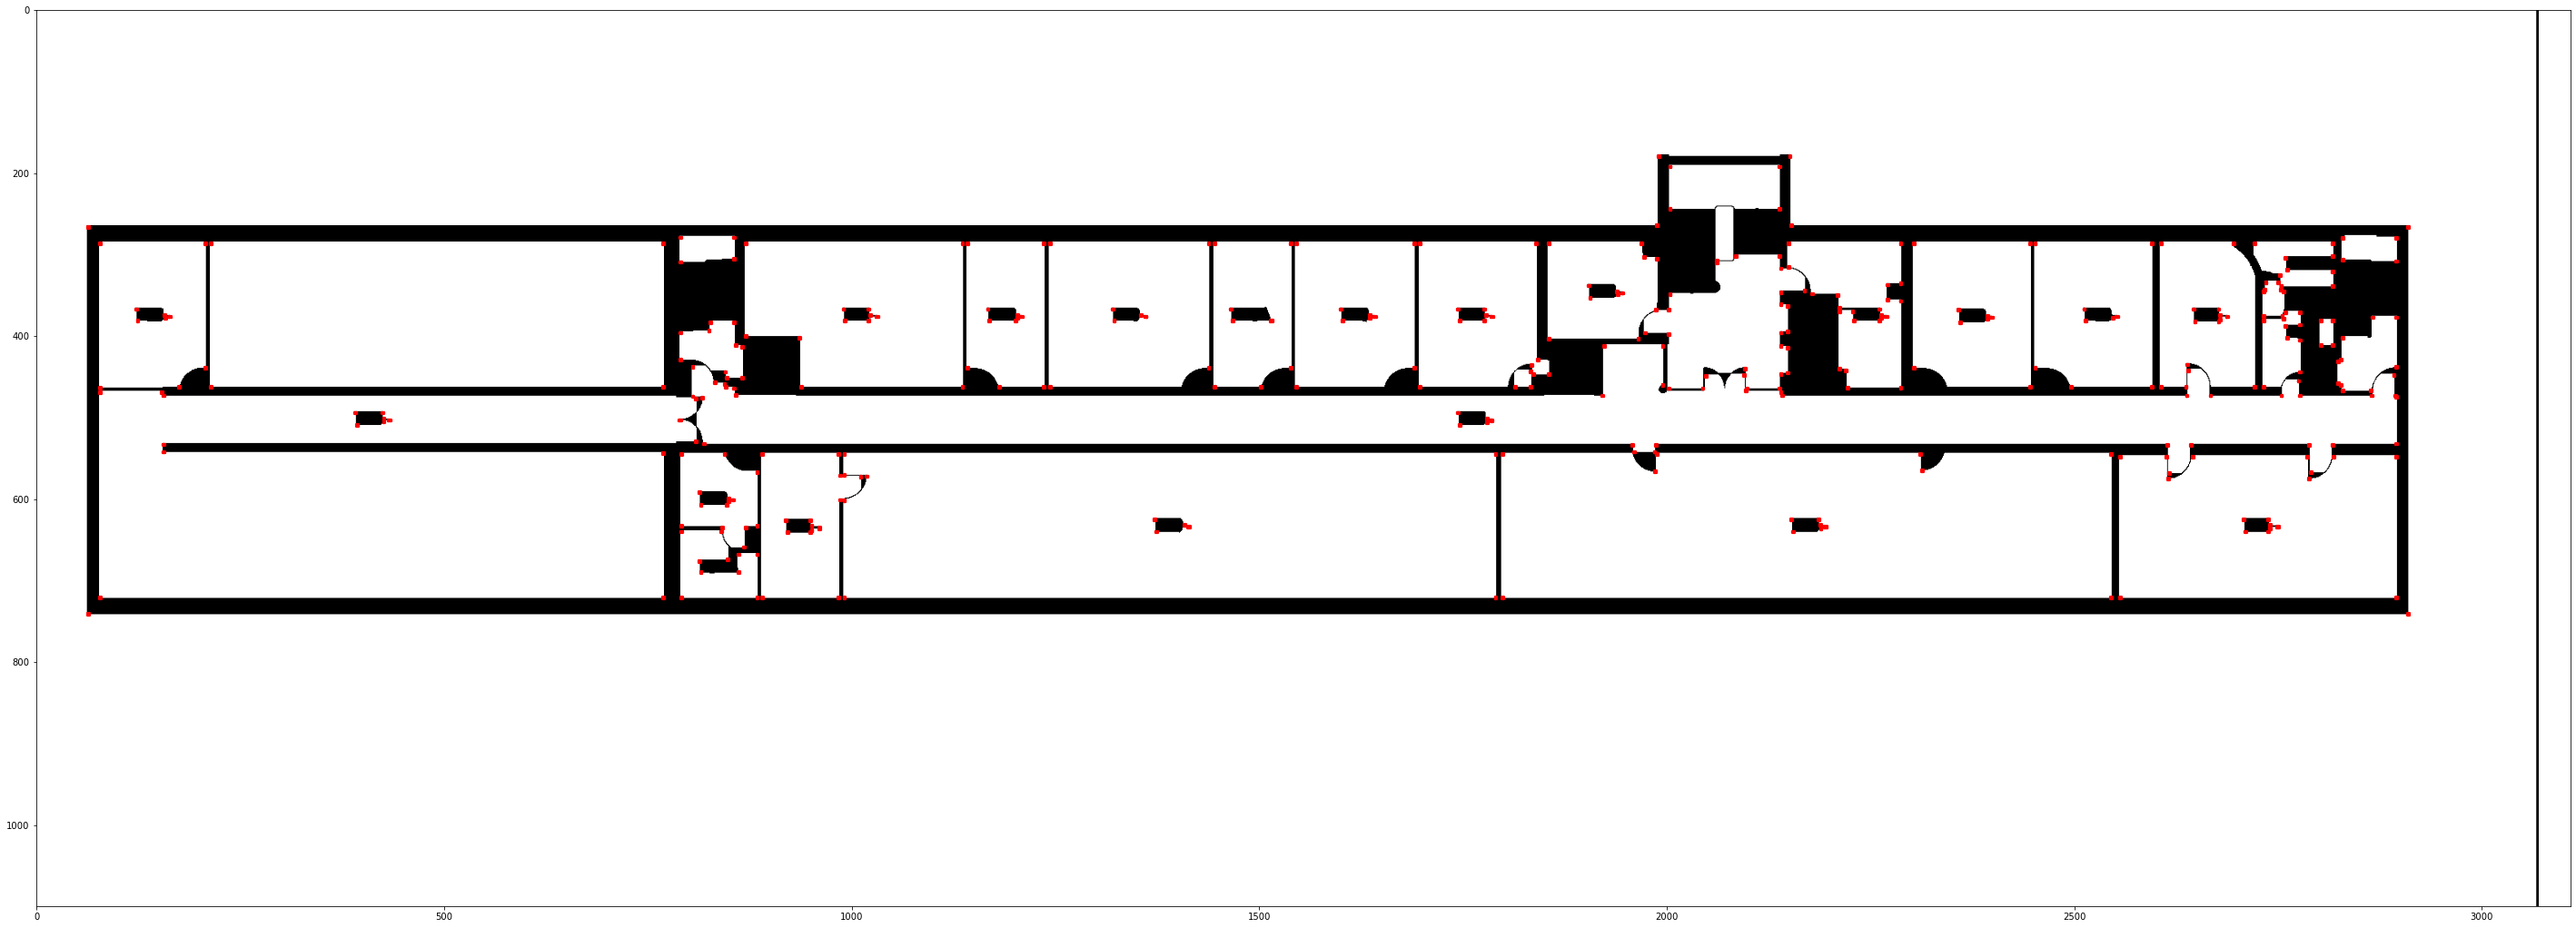

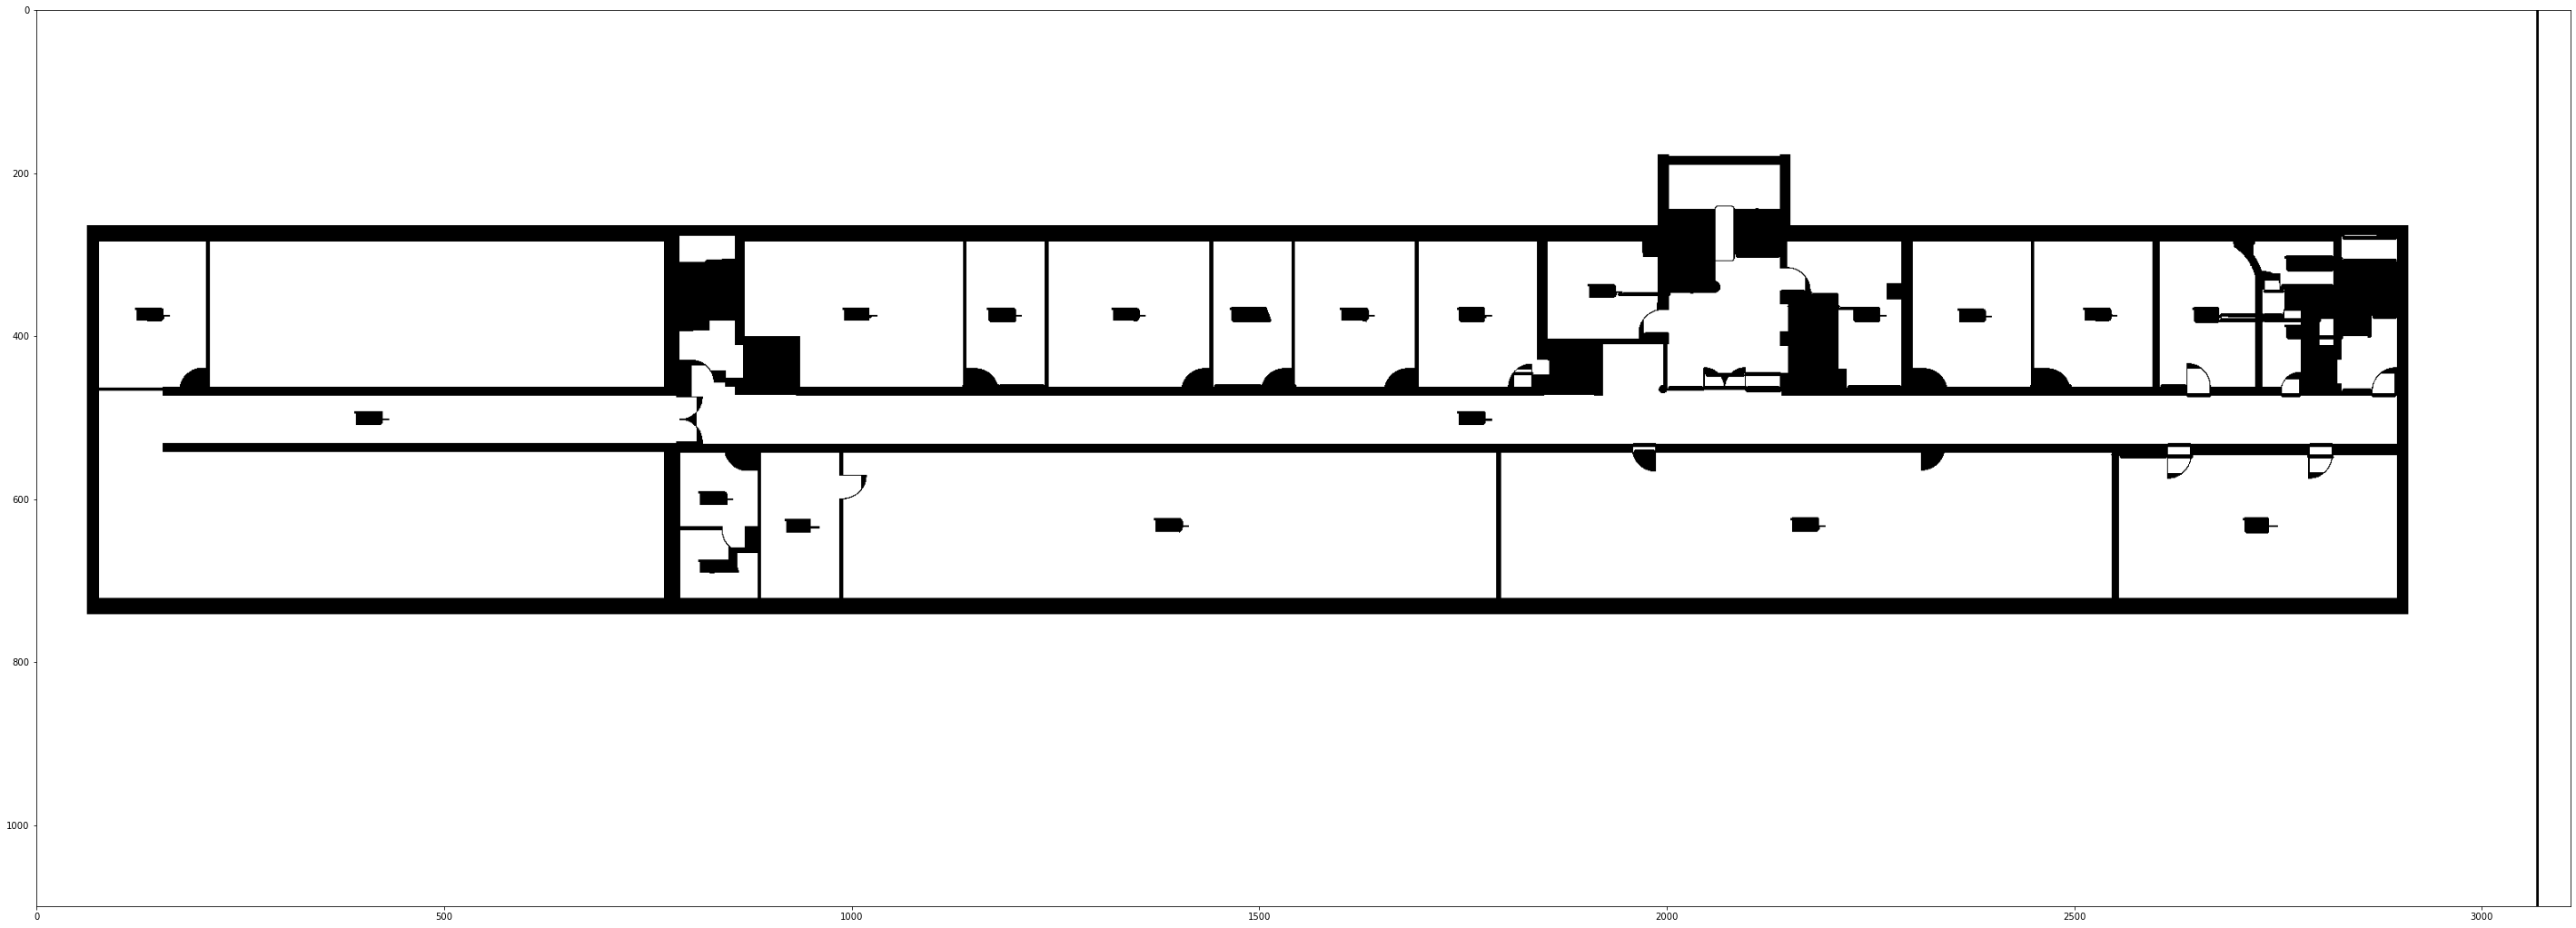

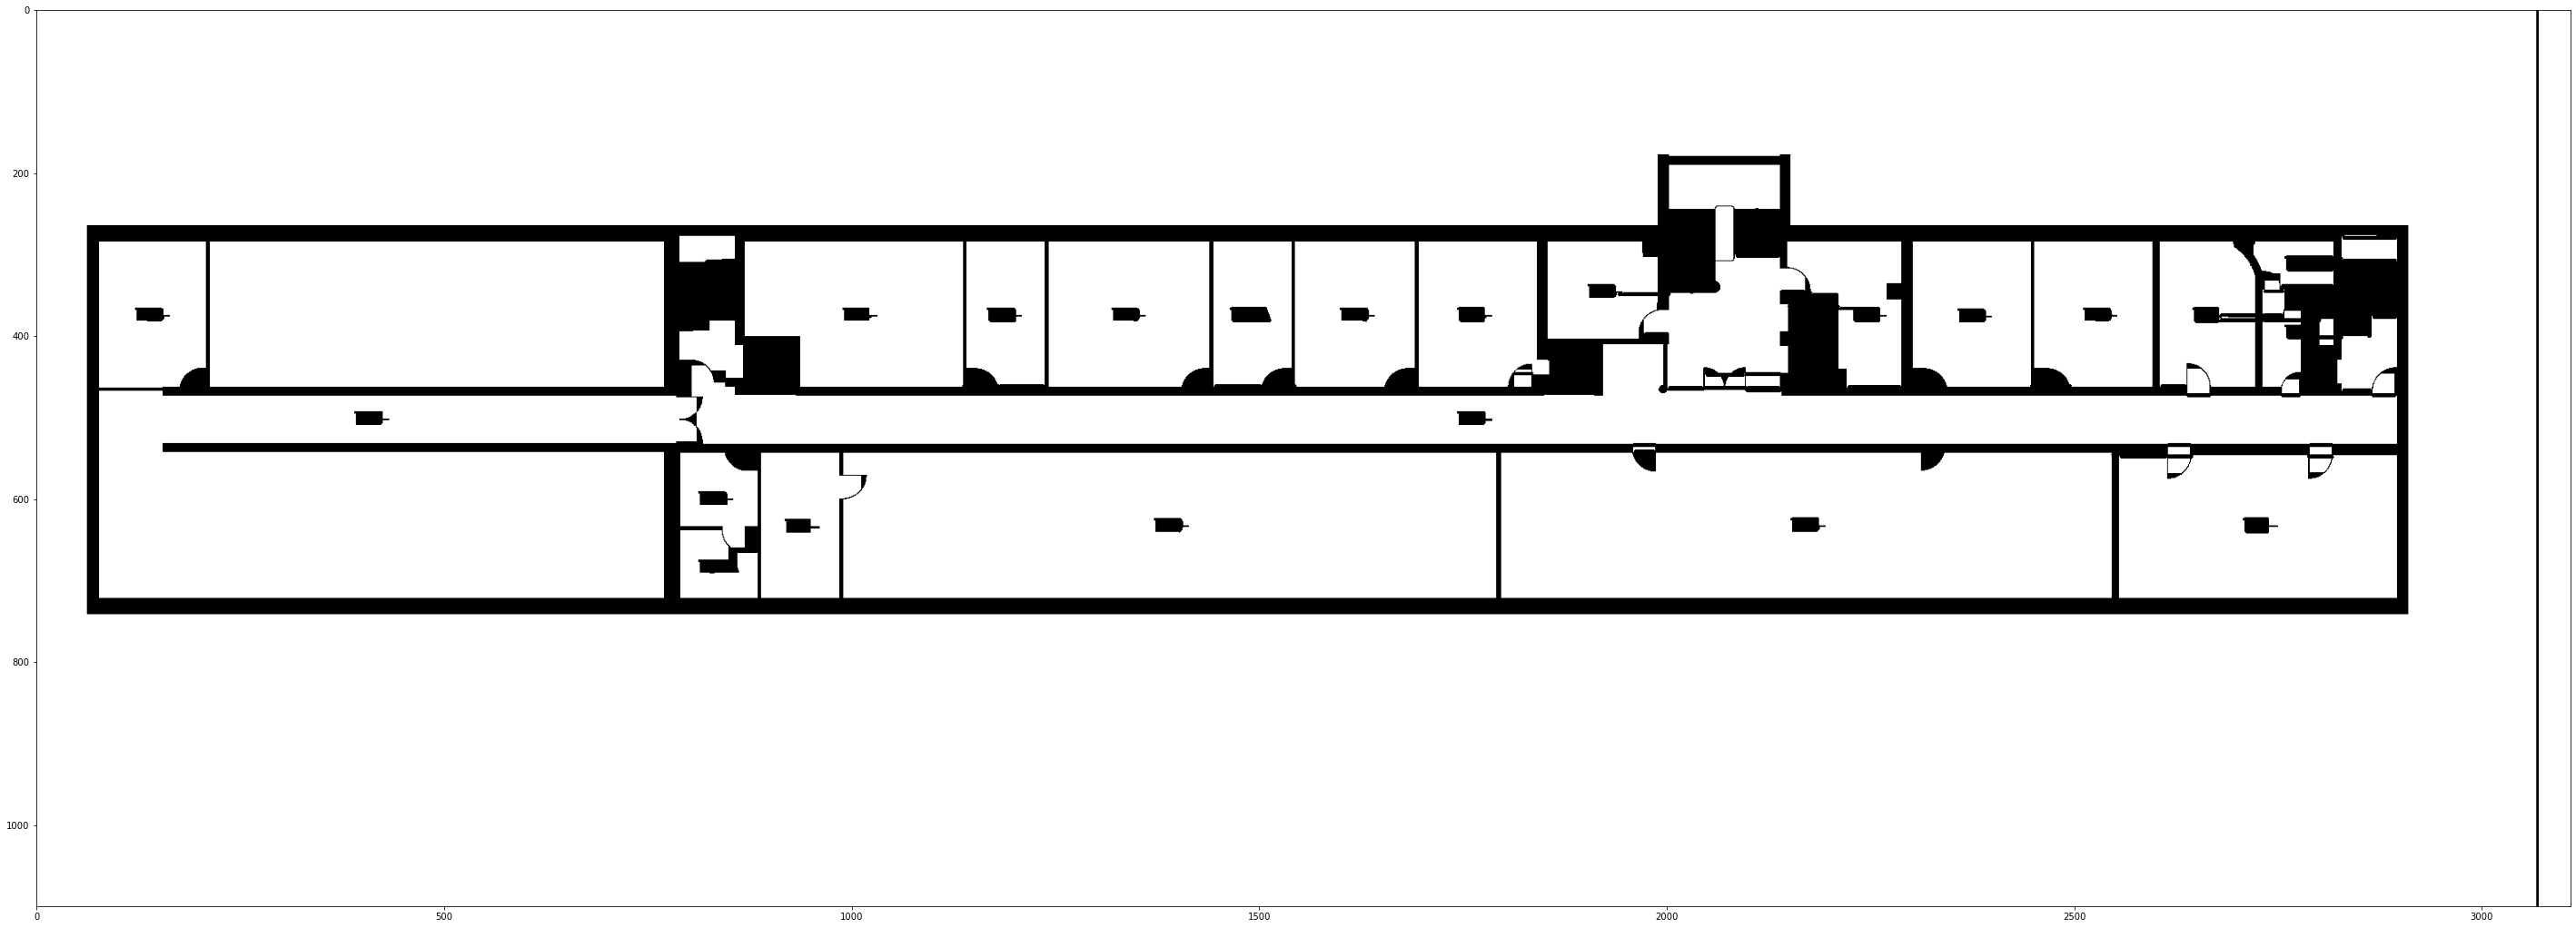

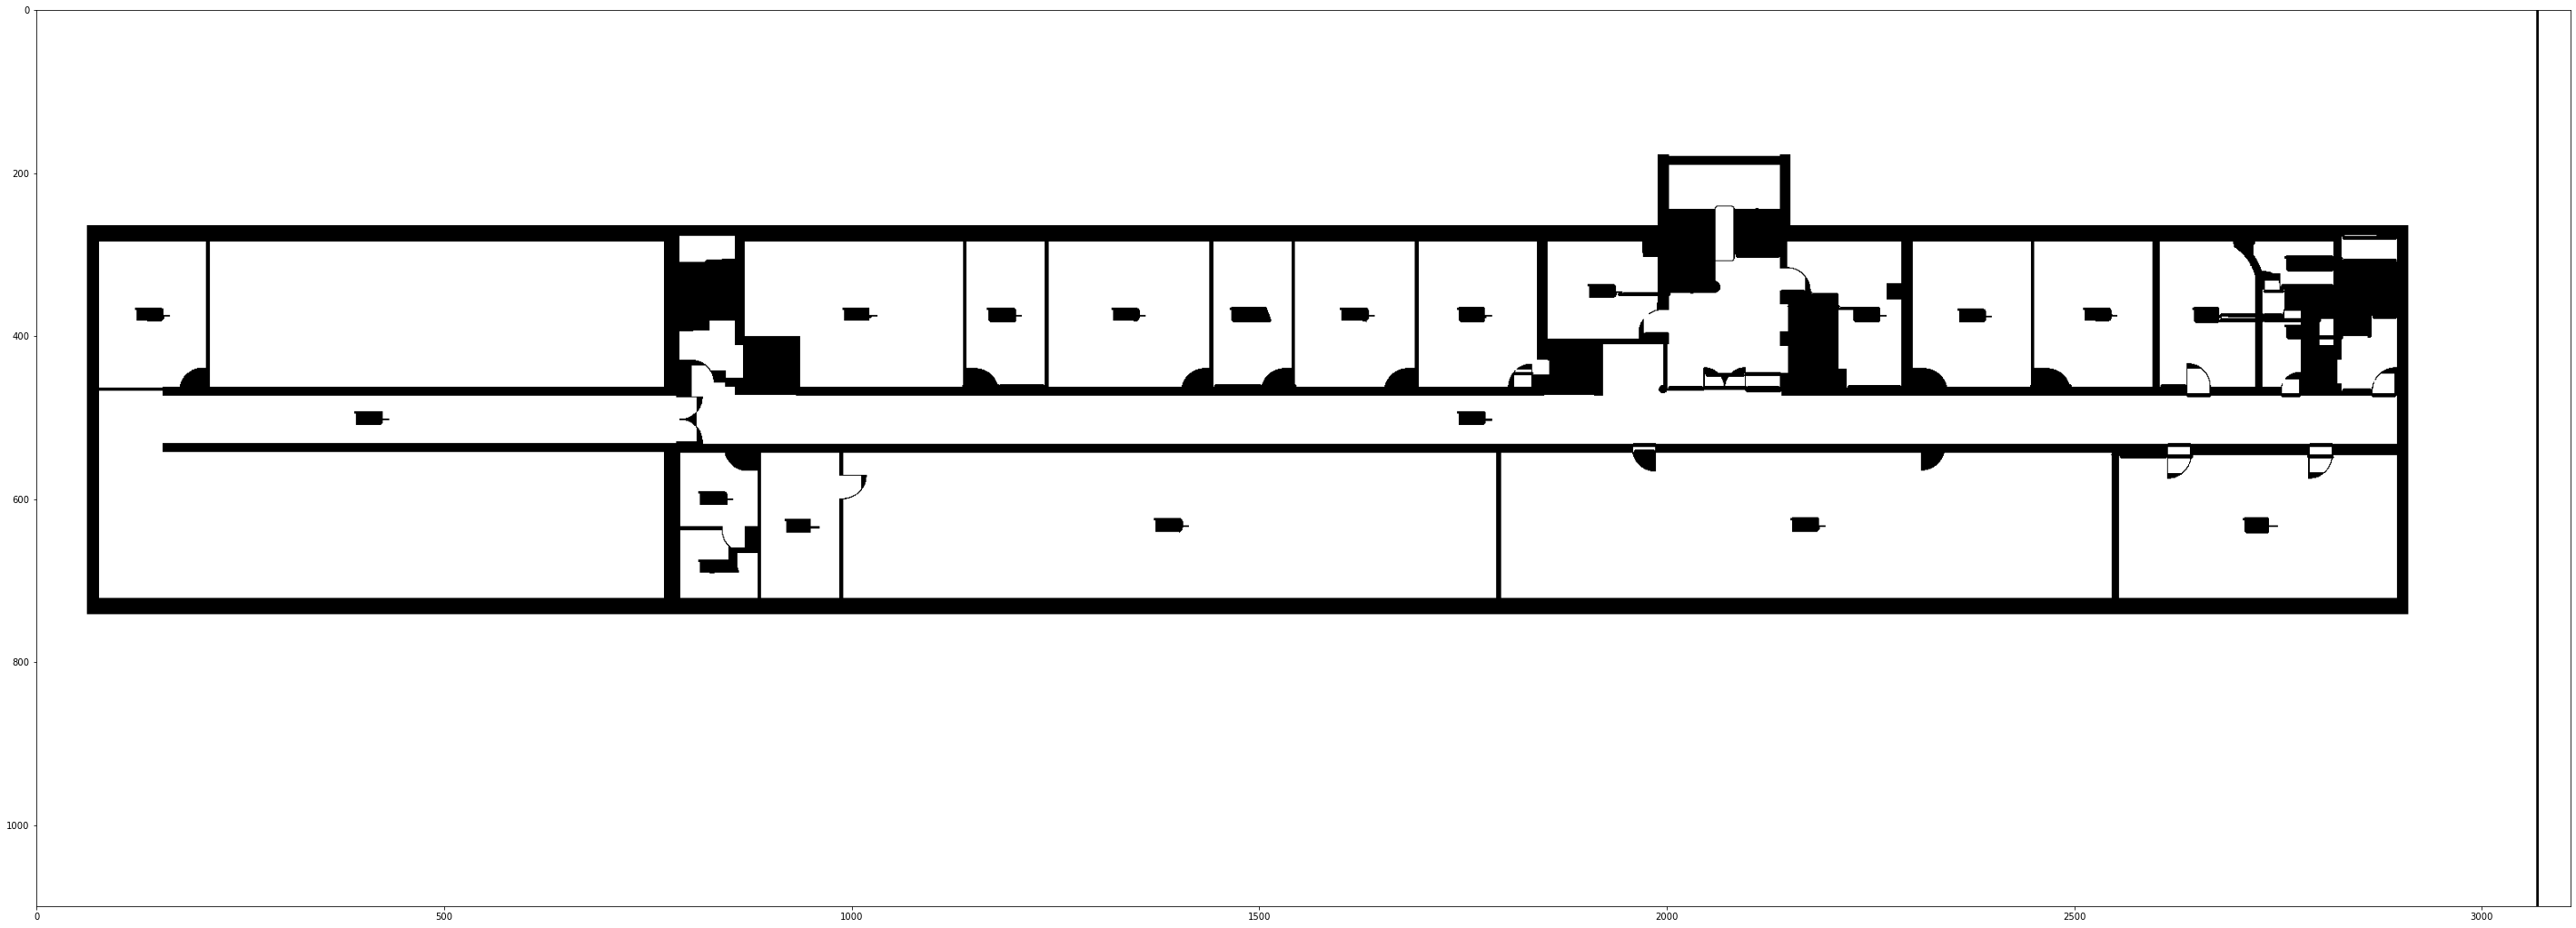

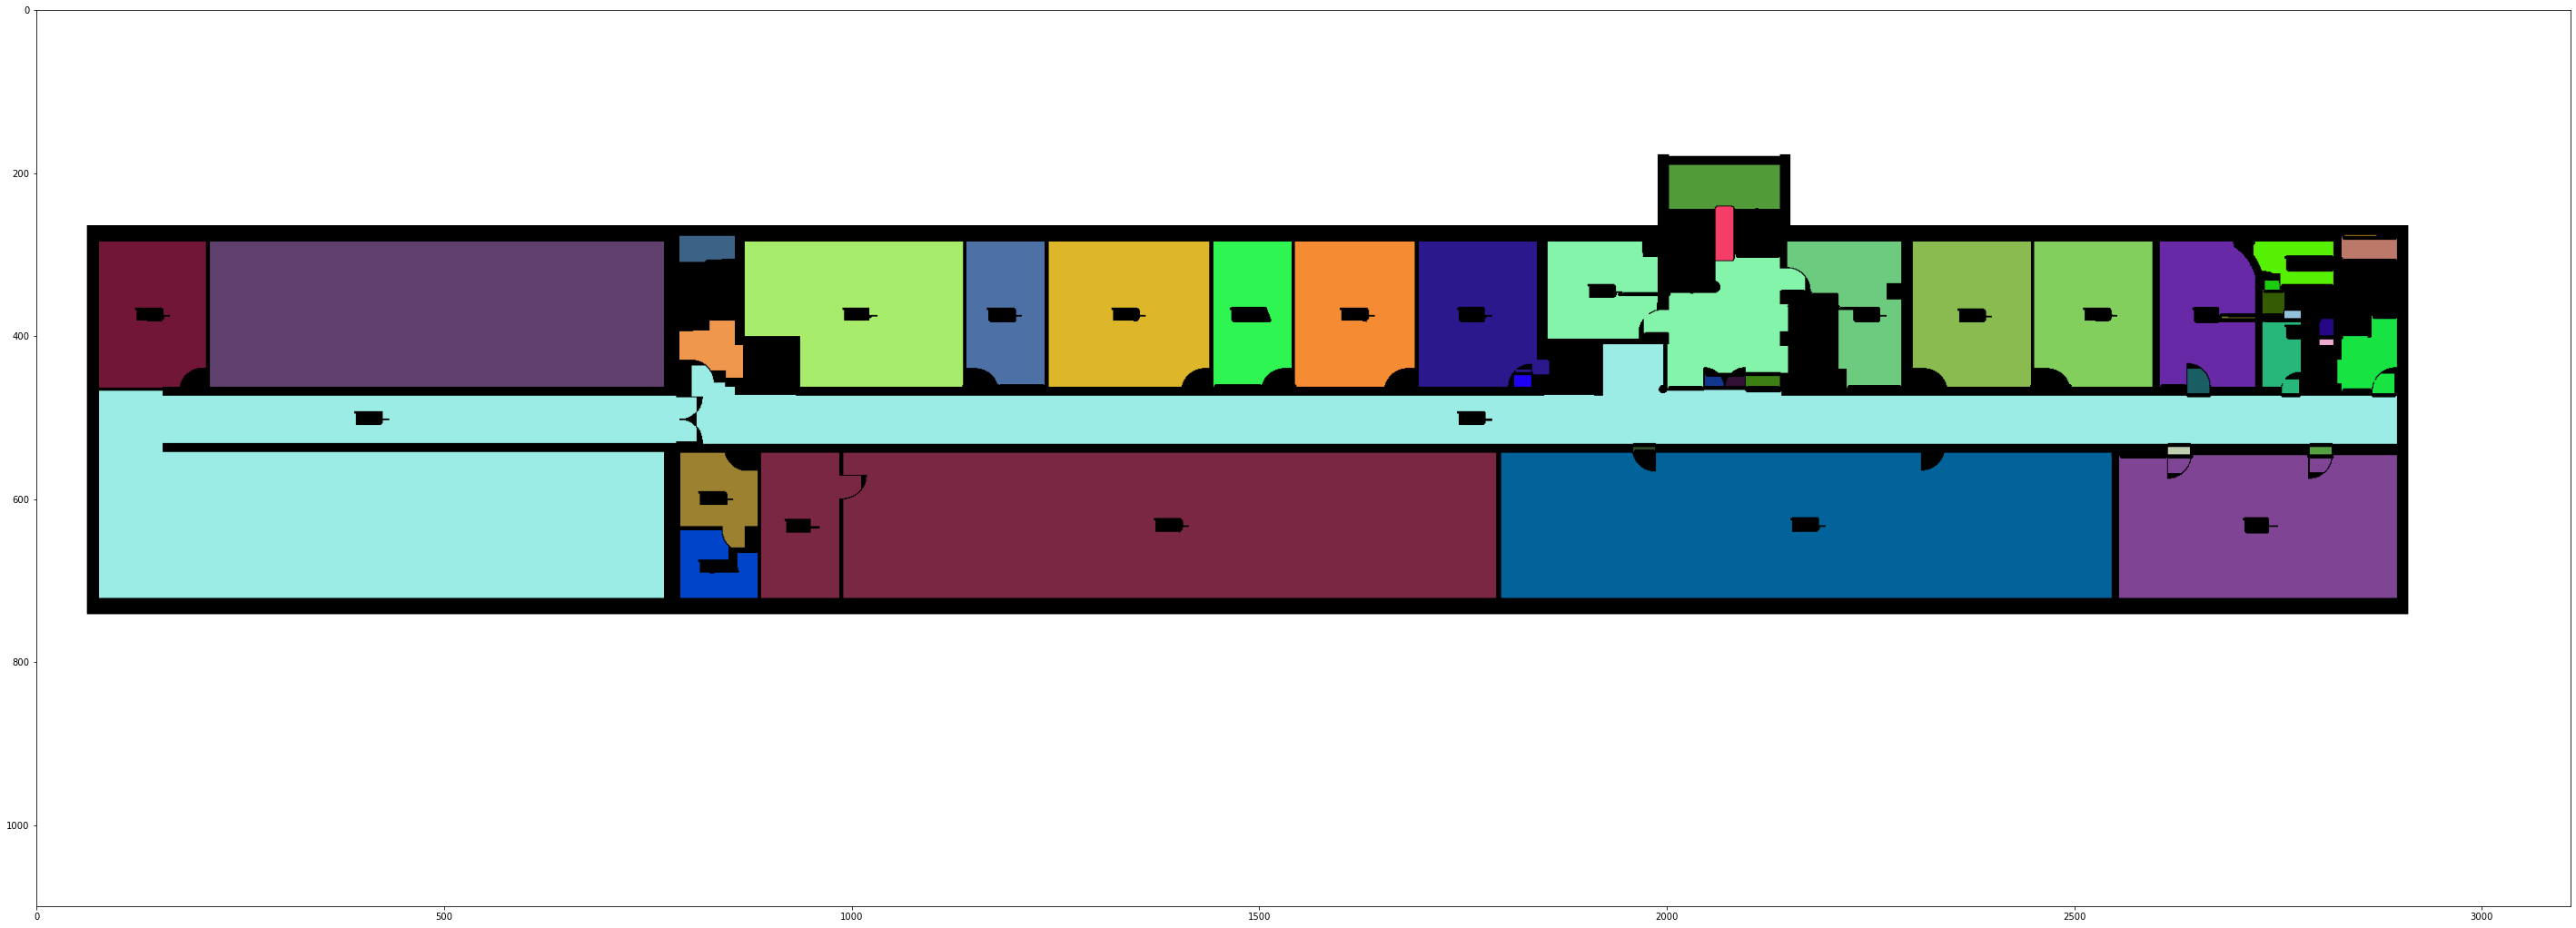

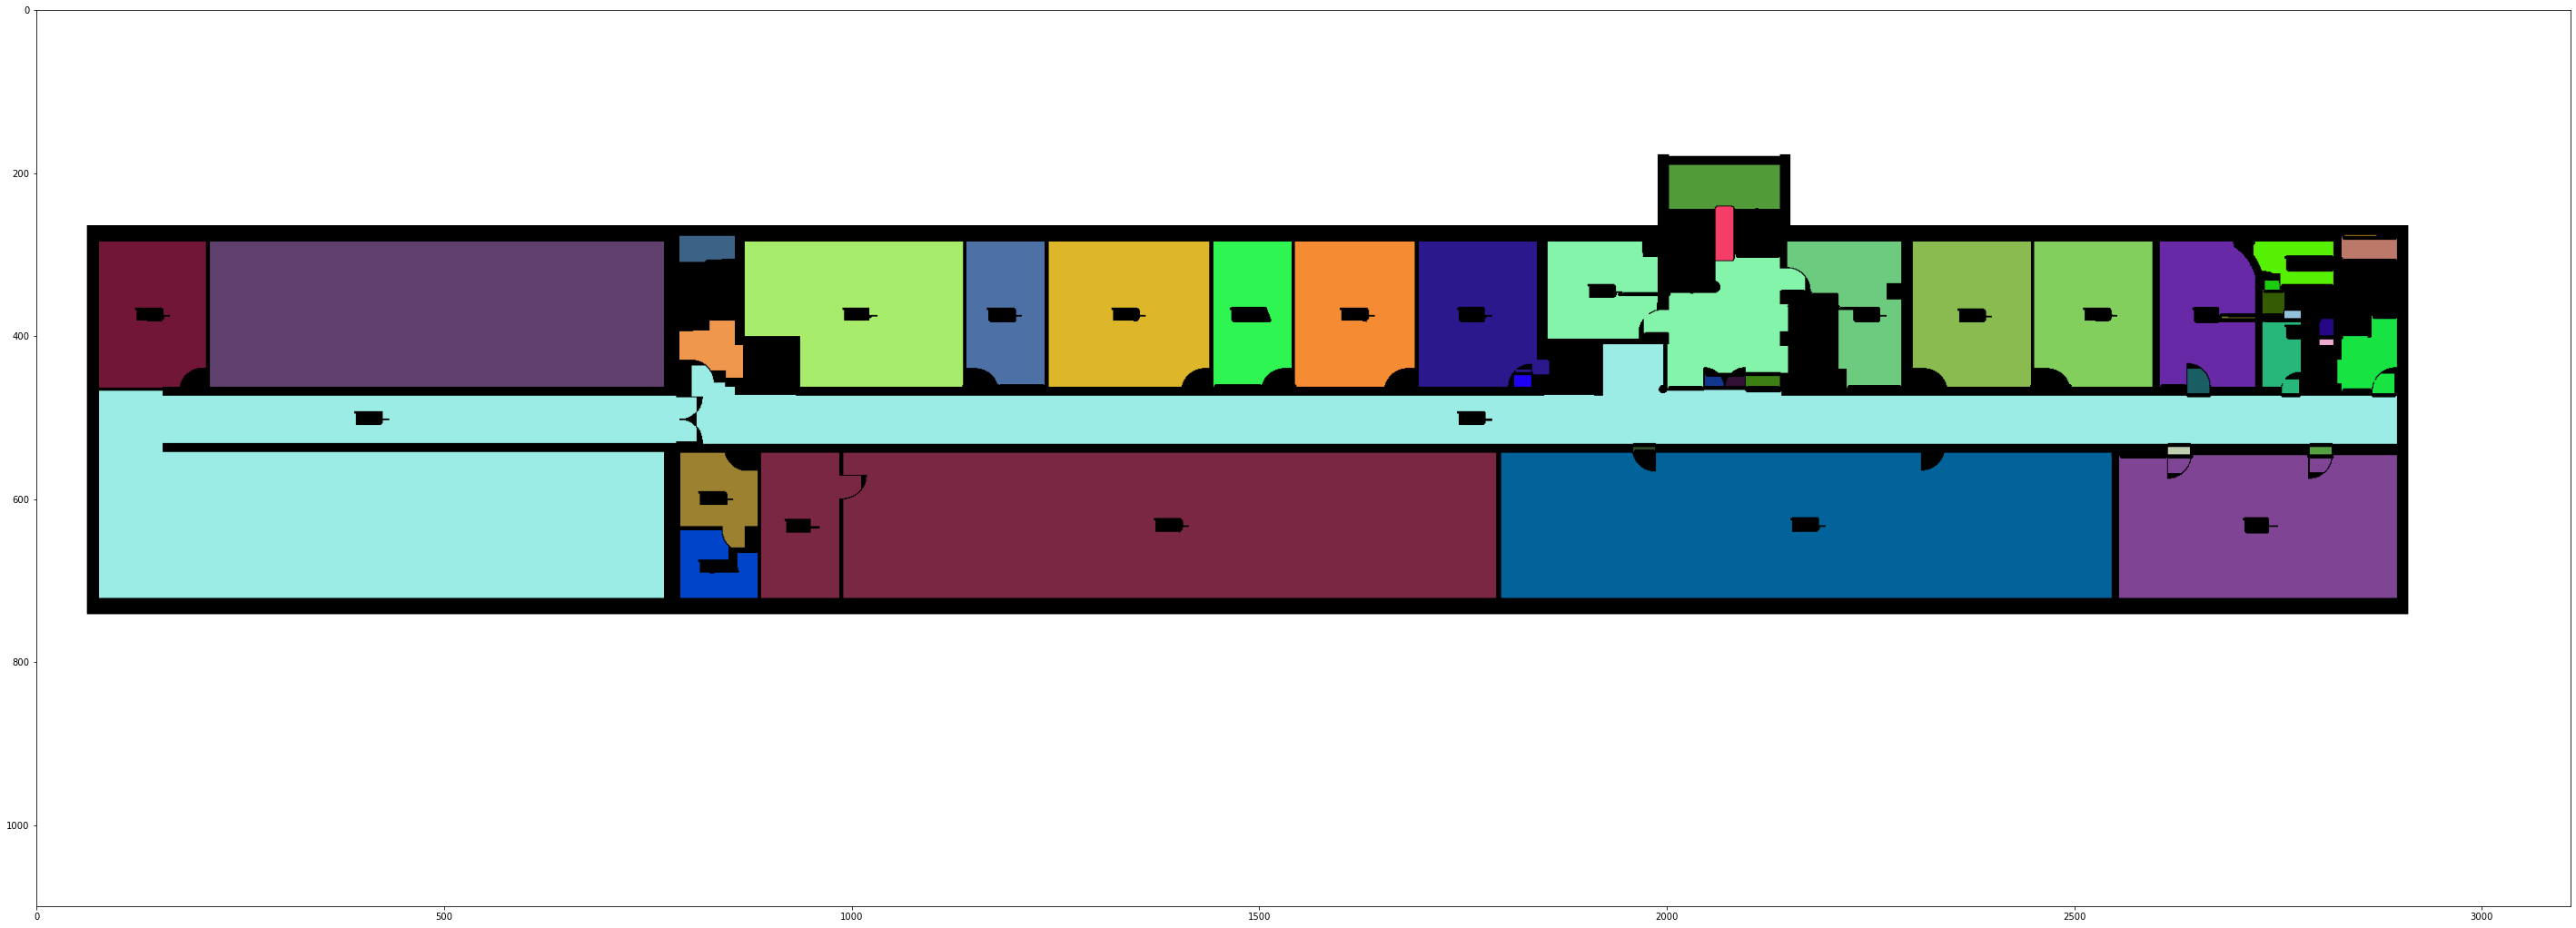

In [30]:
rooms, final_img = obtain_floorplan( img_file, mid_show=True)

In [10]:
# plt.figure(figsize=(50,20))
# stairs = cv2.dilate(img, kernel=np.ones((3,3)), iterations=12)

In [ ]:
for img_file in img_files:
    plt.figure()
    img =  obtain_floorplan(img_file, mid_show=False, stairs=True)
    plt.imsave("dilated/harris/del_"+img_file, img)